In [1]:
!conda install -c conda-forge -y pint-xarray
!pip install pyrtlib
import pint_xarray
import pint
ureg = pint.UnitRegistry()
pint.set_application_registry(ureg)
#pint_xarray.setup_registry(ureg)
import cloud_abs
import miepython
import proplot as pplt
import numpy as np
import xarray as xr
import pyrtlib

#pplt.use_style('seaborn-talk')

pplt.use_style("default")
pplt.rc["legend.facecolor"] = "white"


## 1. Monodispersive Liquid Cloud Absorption Model (VIS Radiation)

This will help you calculate the cloud optical depth for visible light of a cloud with a droplet size distribution that is uniform.  The equations here come from Chapter 7.4.4 of the Grant Petty book.

Input variables for this model include:
- refractive index of water for visible radiation (m)
- radius of fog droplets (r)
- number concentration of droplets per unit volume (N)
- liquid water path (LWP)

This model uses the miepython package to compute extinction efficiencies.

In [2]:
# For a monodisperse cloud - model parameters

m = 1.33-0j # refractive index of water for visible radiation (in reality we need a model for this, since this depends on wavelength and other properties).
#r = 1 * ureg.millimeter # radius of rain drops
r = 10 * ureg.micrometer # radius of fog droplets
wavelength = 0.4 * ureg.micrometer # Visible light
N = 300 * (1./(ureg.meter**3)) # number concentration
LWP = 0.5 * ureg.kilogram / (ureg.meter ** 2) # Liquid water path in kg/m2

print("*** Liquid Cloud Parameters ***")
print(f"Wavelength: {wavelength:~P}")
print(f"Refractive Index: {m}")
print(f"Radius of Liquid Drops: {r:~P}")
print(f"Droplet Number Concentration: {N:~P}")
print(f"Liquid Water Path: {LWP:~P}")
print()

print("*** Derived Parameters ***")
# Calculations for the monodisperse cloud:
x = (2 * np.pi * r)/(wavelength) # Compute the size parameter for these droplets
print(f"Droplet Size Parameter: {x.to_base_units():0.1f}")
cloud_abs.scattering_regimes(x)
print()

Qe, _, _, _ = miepython.mie(m=m, x=x.to_base_units().magnitude) # Use Mie theory to figure out the extinction efficiency (which should be close to 2).

Beta_e = N * Qe * np.pi * r**2 # Extinction Coefficient

# Cloud water density
rho_l = 1000 * ureg.kilogram / (ureg.meter ** 3) # kg/m3 (density of pure water)
rho_w = N * (4./3.) * np.pi * r **3 * rho_l # Cloud water density (kg/m3)

mass_extinction_coeff = 3. * Qe / (4. * rho_l * r)
Cloud_Optical_Depth = mass_extinction_coeff * LWP

print("*** Extinction Variables ***")
print(f"Volume Extinction Coefficient: {Beta_e.to_base_units():~P}")
print(f"Extinction Efficiency: {Qe:0.2f}")
print(f"Mass Extinction Coefficient: {mass_extinction_coeff.to_base_units().round(4):~P}")
print(f"Liquid Water Path: {LWP:~P}")
print(f"Cloud Optical Depth: {Cloud_Optical_Depth.to_base_units().round(4):~P}")
print(f"Cloud Transmissivity: {np.exp(-Cloud_Optical_Depth.to_base_units()).round(9):~P}")

*** Liquid Cloud Parameters ***
Wavelength: 0.4 µm
Refractive Index: (1.33+0j)
Radius of Liquid Drops: 10 µm
Droplet Number Concentration: 300.0 1/m³
Liquid Water Path: 0.5 kg/m²

*** Derived Parameters ***
Droplet Size Parameter: 157.1 dimensionless
Scattering Regime: Mie

*** Extinction Variables ***
Volume Extinction Coefficient: 1.9591215414126068×10⁻⁷ 1/m
Extinction Efficiency: 2.08
Mass Extinction Coefficient: 155.9019 m²/kg
Liquid Water Path: 0.5 kg/m²
Cloud Optical Depth: 77.951
Cloud Transmissivity: 0.0


# 2. Liquid/Ice Cloud Absorption Model (IR Radiation; from Turner 2005)

This will help you calculate the cloud optical depth for IR radiation using a ice or liquid cloud with a Gamma droplet size distribution.  The equations here come from Dave Turner's PhD Dissertation as well as the single-scattering databases.

Input variables for this model include:
- effective radius of cloud droplets (r)
- cloud thickness (cloud_thickness)
- liquid water path (LWP)

This model uses pre-computed scattering properties from a Mie program instead of calculating them on-demand.

*** Cloud Model Input Parameters ***
Liquid Water Path: 20.0 g/m²
Effective Radius: 0.1 mm
Cloud Layer Thickness: 300 m
Cloud Optical Depth (visible wavelength): 0.3
Done computing the ice and liquid cloud optical depths...


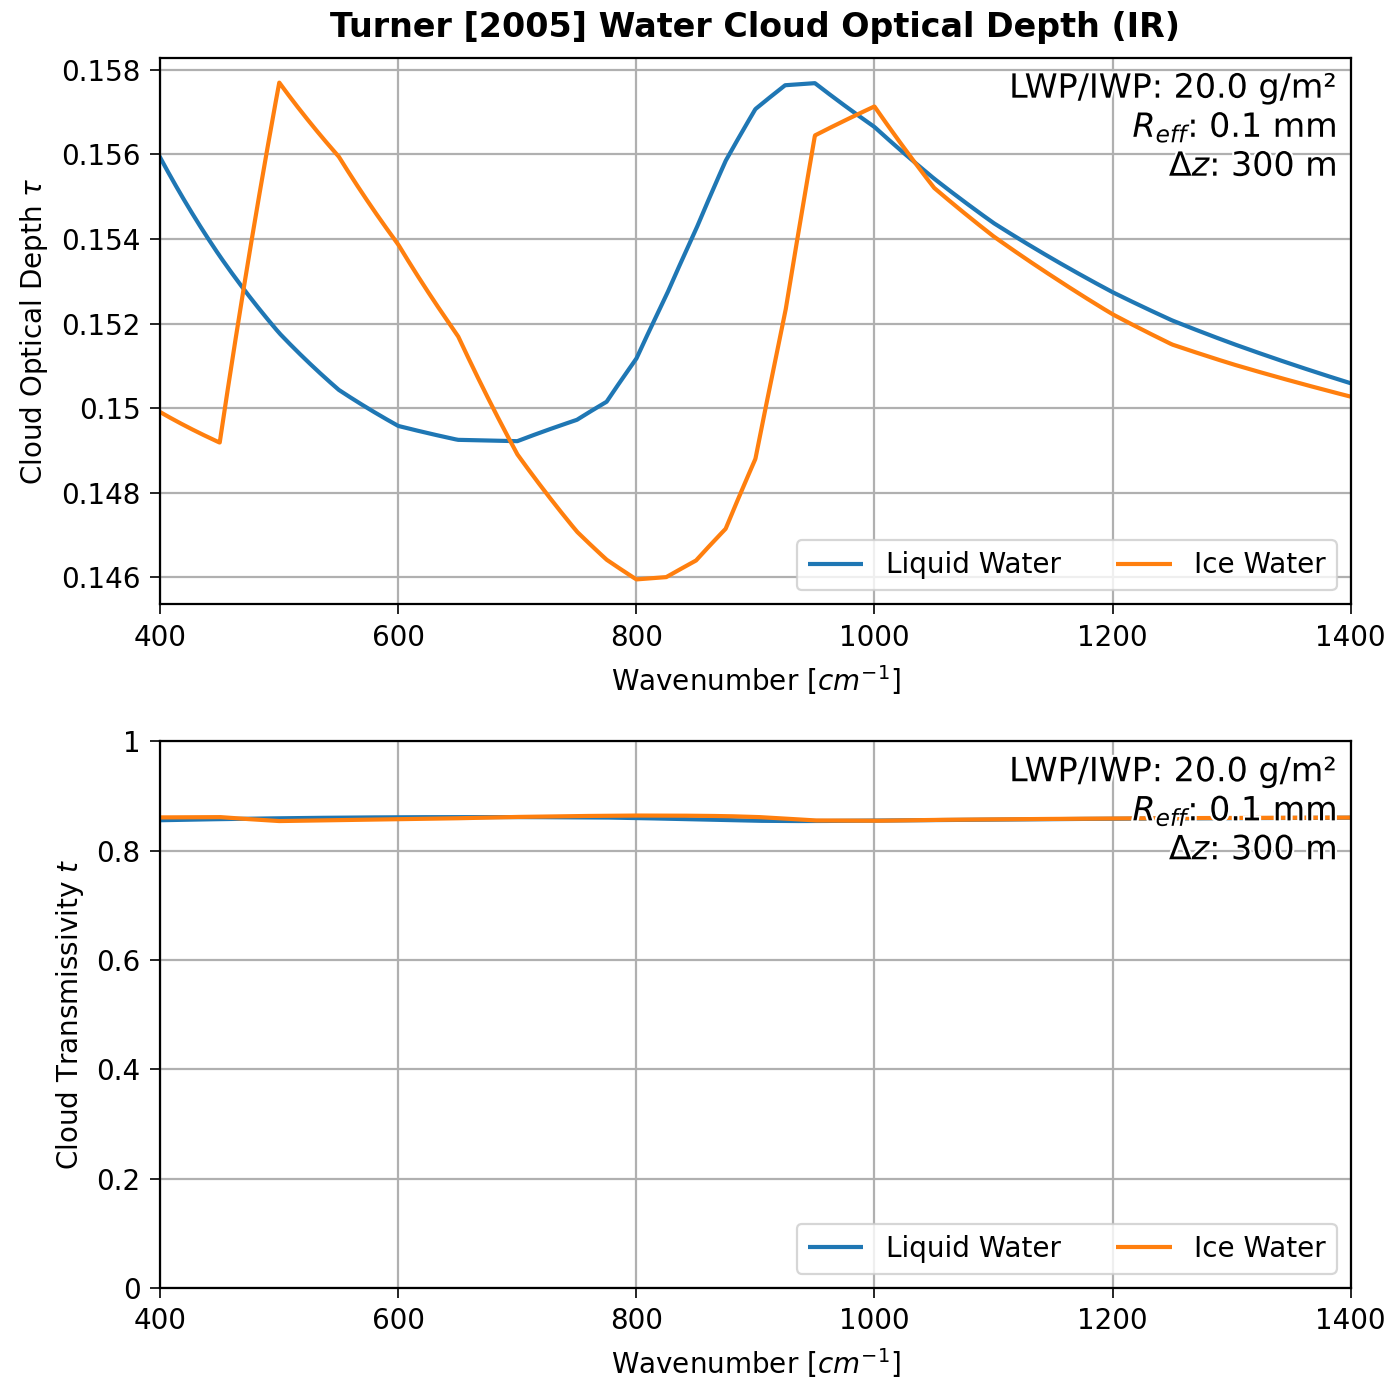

In [3]:
#### MODEL INPUT PARAMETERS
reff = 0.1 * ureg.millimeter # radius of rain drops
LWP = 20 * ureg.gram / (ureg.meter ** 2)
cld_thickness = 300 * ureg.Unit('meter')
wnum_grid = np.linspace(400,1400,3000) * pint.Unit('1/cm') # Use wavenumber units.

print("*** Cloud Model Input Parameters ***")
print(f"Liquid Water Path: {LWP:~P}")
print(f"Effective Radius: {reff:~P}")
print(f"Cloud Layer Thickness: {cld_thickness:~P}")
cldodvis = cloud_abs.vis_cloud_od(LWP, reff)
print(f"Cloud Optical Depth (visible wavelength): {cldodvis:~P}")

# Load in the single-scattering databases (from Dave Turner)
ssp_liqwat = xr.open_dataset('ssp_db.mie_wat.gamma_sigma_0p100.cdf')
ssp_icewat = xr.open_dataset('ssp_db.mie_ice.gamma_sigma_0p100.cdf')

cloud_properties = f"LWP/IWP: {LWP:~P}\n$R_{{eff}}$: {reff:~P}\n$\Delta z$: {cld_thickness:~P}"

# Convert the visible cloud optical depth to the optical depth of the IR spectrum
liq_cloud_tau = cloud_abs.get_ir_cloud_ods(ssp_liqwat, cldodvis, wnum_grid, reff, cld_thickness)
ice_cloud_tau = cloud_abs.get_ir_cloud_ods(ssp_icewat, cldodvis, wnum_grid, reff, cld_thickness)

print("Done computing the ice and liquid cloud optical depths...")

fig, ax = pplt.subplots(ncols=1, nrows=2, figsize=(7,7), sharex=False, sharey=False)
ax[0].plot(wnum_grid, liq_cloud_tau, label="Liquid Water")
ax[0].plot(wnum_grid, ice_cloud_tau, label="Ice Water")
ax[0].legend(loc='lr')
ax[0].format(xlabel="Wavenumber [$cm^{-1}$]", ylabel=r"Cloud Optical Depth $\tau$", 
           urtitle=f"{cloud_properties}", grid=True,
           suptitle="Turner [2005] Water Cloud Optical Properties (IR)")
ax[1].plot(wnum_grid, np.exp(-liq_cloud_tau), label="Liquid Water")
ax[1].plot(wnum_grid, np.exp(-ice_cloud_tau), label="Ice Water")
ax[1].legend(loc='lr')
ax[1].format(xlabel="Wavenumber [$cm^{-1}$]", ylabel=r"Cloud Transmissivity $t$", 
           urtitle=f"{cloud_properties}", grid=True, ylim=(0,1),
           suptitle="Turner [2005] Water Cloud Optical Depth (IR)")
pplt.show()

# 3. Liquid/Ice Cloud Absorption Model (Microwave; PyRTLib Model)

The liquid water model is dependent on the temperature of the liquid in Kelvin.  The IWP and LWP helps specify the degree of liquid water and ice in the cloud.

[273] [0.33333333] [0.33333333]


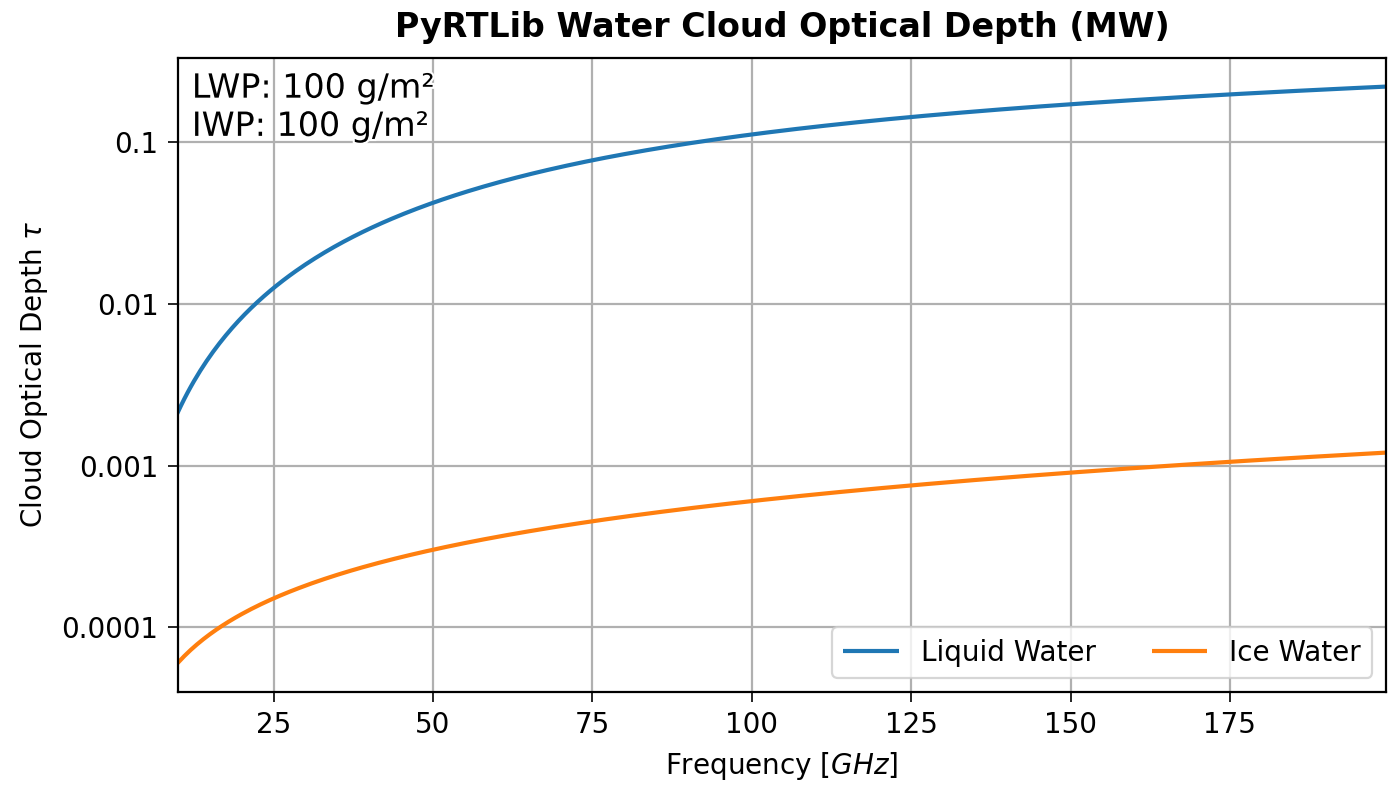

In [9]:
cloud_temperature = 273 # Kelvin
LWP = 100 * ureg.Unit("gram meter ** -2")
IWP = 100 * ureg.Unit("gram meter ** -2")
frq = np.arange(10, 200, .5) # Frequencies in GHz

cloud_properties = f"LWP: {LWP:~P}\nIWP: {IWP:~P}"

liqtau, icetau = cloud_abs.mw_cloud_model(cloud_temperature, LWP.to("gram meter ** -2").magnitude, 
                                            IWP.to("gram meter ** -2").magnitude, frq)
fig, ax = pplt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.format(ultitle=cloud_properties)
fig.format(xlabel="Frequency [$GHz$]", ylabel=r"Cloud Optical Depth $\tau$", grid=True,
           suptitle="PyRTLib Water Cloud Optical Depth (MW)", yscale='log')

ax[0].plot(frq, liqtau, label="Liquid Water")
ax[0].plot(frq, icetau, label="Ice Water")
ax.legend(loc='lr')
pplt.show()